In [226]:
#Iterative Model
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso, Ridge, LinearRegression, ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error 

In [262]:
def impute(df):
    countries = df.country.unique()
    #dataset averages
    global_h = np.mean(df.height)
    global_w = np.mean(df.weight)
    global_a = np.mean(df.age)

    heights = []
    weights = []
    ages = []
    #steps through each country
    for co in countries:
        group = df[df['country'] == co]
        # counting datapoints within country
        count_h = np.count_nonzero(~np.isnan(group.height))
        count_w = np.count_nonzero(~np.isnan(group.weight))
        count_a = np.count_nonzero(~np.isnan(group.age))
        # sets thresholds between accepting the countries average or using dataset average to fill in NaN's
        if count_h >= 5:
            avg_h = np.mean(group.height)
        else:
            avg_h = global_h
        if count_w >= 5:
            avg_w = np.mean(group.weight)
        else:
            avg_w = global_w
        if count_a >= 10:
            avg_a = np.mean(group.age)
        else:
            avg_a = global_a
        # steps through each person creating lists to replace current columns in dataframe
        for i in range(len(group)):
            if np.isnan(group.iloc[i].height):
                heights.append(avg_h)
            else:
                heights.append(group.iloc[i].height)
            if np.isnan(group.iloc[i].weight):
                weights.append(avg_w)
            else:
                weights.append(group.iloc[i].weight)
            if np.isnan(group.iloc[i].age) or group.iloc[i].age==0:
                ages.append(avg_a)
            else:
                ages.append(group.iloc[i].age)
    #replacing columns of dataframe 
    imputed = df.copy()
    imputed['height'] = heights
    imputed['weight'] = weights
    imputed['age'] = ages
    return imputed.fillna(0)

In [263]:
#using a iterative model to predict 
#training and testing data
df = pd.read_csv('../data/men_lead_no_drop.csv')
# df = df.set_index('id')
df = impute(df)

In [264]:
#training_data
df_ = df.drop(['last_name', 'first_name', 'points', 'rank','country'], axis=1)
train = df[df.year<=2014]
# id_finder = train[train.year == 2014]
# ids = id_finder.id
train = train.drop(['id','last_name', 'first_name', 'points', 'rank','country'], axis=1)
X_train = train.drop(['avg_points'],axis =1)
y_train = train['avg_points']
# iteratively stepping through the years


In [280]:
def Predict_check(start_yr,number_yrs):   
    param_grid = {
        'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4],
        'fit_intercept': [True, False],
        'normalize': [True, False]
    }
    model = Ridge(max_iter=100000)
    grid = GridSearchCV(model, param_grid, n_jobs=-1, scoring='neg_mean_squared_error').fit(X_train, y_train)
    year = df_[df_.year ==start_yr].drop('avg_points',axis = 1)
    start_yr_ids = set(year.id)
    for _ in range(number_yrs):
        pred = grid.predict(year.drop('id',axis = 1))
        year['t-1'],year['t-2'],year['t-4'],year['t-5'],year['t-6'],year['t-7'] = pred,year['t-1'],year['t-2'],year['t-4'],year['t-5'],year['t-6']
    #finding actuals
    year['pred'] = pred
    forward_yr_ids = set(df[df.year == start_yr + number_yrs].id)
    ids = list(forward_yr_ids.intersection(start_yr_ids))
    check_pred = df[df.year == start_yr + number_yrs]
    check_pred = check_pred[check_pred['id'].isin(ids)]
    pred = year[year['id'].isin(ids)]
    print(len(pred))
    return (mean_squared_error(pred.pred,check_pred.avg_points))

46
43
31
28
21
18


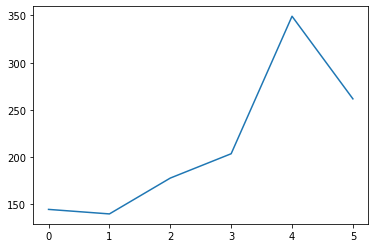

In [281]:
plt.plot([Predict_check(2012,i) for i in range(1,7)])

In [279]:
#predicted average score of top 5 people
#people who were actually the top 5

UnboundLocalError: local variable 'pred' referenced before assignment